# Implementing the U-Net Architecture
The paper uses a U-Net architecture for doing the image inpainting, which has been implemented in the `libs/pconv_model.py` module. First let us get required packages.

In [1]:
import os
import gc
from copy import deepcopy
import cv2

import numpy as np
from PIL import Image

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard, ModelCheckpoint, LambdaCallback

import matplotlib
import matplotlib.pyplot as plt

# Change to root path
if os.path.basename(os.getcwd()) != 'PConv-Keras':
    os.chdir('..')

from libs.util import MaskGenerator
from libs.pconv_model_mod import PConvUnet

# Settings
BATCH_SIZE = 4

# Imagenet Rescaling
MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])

Using TensorFlow backend.


In [2]:
PConvUnet().summary()

















__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs_img (InputLayer)         (None, 400, 400, 3)  0                                            
__________________________________________________________________________________________________
inputs_mask (InputLayer)        (None, 400, 400, 3)  0                                            
__________________________________________________________________________________________________
p_conv2d_1 (PConv2D)            [(None, 200, 200, 64 9472        inputs_img[0][0]                 
                                                                 inputs_mask[0][0]                
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 200, 200, 64) 0           p_conv2d_1[0][0]            

Shape of image is: (400, 400, 3)


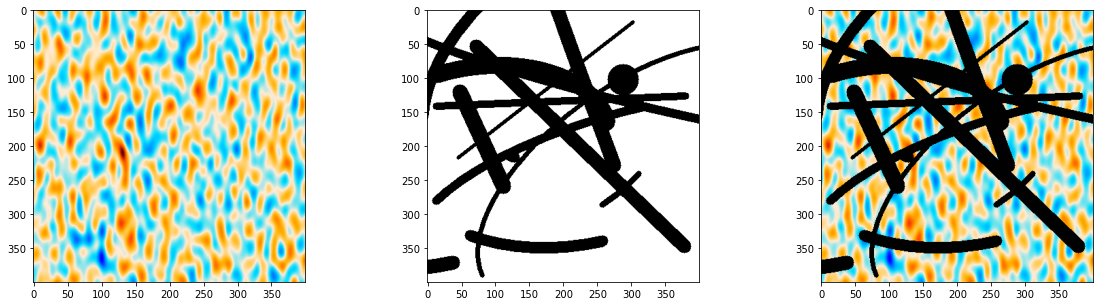

In [3]:
# Load image
img = cv2.imread('/Users/emmyli/School/Winter_Quarter_2021/CS_230/inpainting-cmb/datasets/train/0pict.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
shape = img.shape
print(f"Shape of image is: {shape}")

# Instantiate mask generator
mask_generator = MaskGenerator(shape[0], shape[1], 3, rand_seed=42)

# Load mask
mask = mask_generator.sample()

# Load a mask from the mask dataset
# mask = cv2.imread('/Users/emmyli/School/Winter_Quarter_2021/CS_230/inpainting-cmb/datasets/mask/0pict.png')


# Image + mask
masked_img = deepcopy(img)
masked_img[mask==0] = 1

# Show side by side
_, axes = plt.subplots(1, 3, figsize=(20, 5))
axes[0].imshow(img)
axes[1].imshow(mask * 255)
axes[2].imshow(masked_img)
plt.show()

In [4]:
def plot_sample_data(masked, mask, ori, middle_title='Raw Mask'):
    _, axes = plt.subplots(1, 3, figsize=(20, 5))
    axes[0].imshow(masked[:,:,:])
    axes[0].set_title('Masked Input')
    axes[1].imshow(mask[:,:,:])
    axes[1].set_title(middle_title)
    axes[2].imshow(ori[:,:,:])
    axes[2].set_title('Target Output')
    plt.show()

class DataGenerator(ImageDataGenerator):
    def flow(self, x, *args, **kwargs):
        while True:
            
            # Get augmentend image samples
            ori = next(super().flow(x, *args, **kwargs))

            # Get masks for each image sample
            mask = np.stack([mask_generator.sample() for _ in range(ori.shape[0])], axis=0)

            # Apply masks to all image sample
            masked = deepcopy(ori)
            masked[mask==0] = 1

            # Yield ([ori, masl],  ori) training batches
            # print(masked.shape, ori.shape)
            gc.collect()
            yield [masked, mask], ori        

# Create datagen
datagen = DataGenerator(  
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Create generator from numpy array
batch = np.stack([img for _ in range(BATCH_SIZE)], axis=0)
generator = datagen.flow(x=batch, batch_size=BATCH_SIZE)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


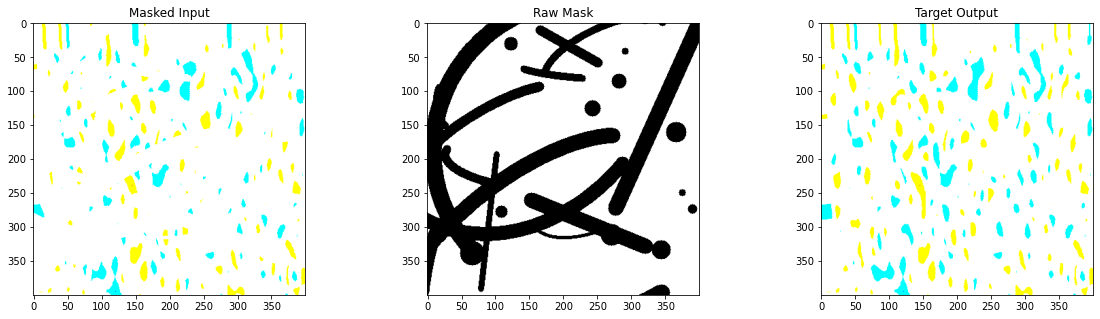

In [5]:
[m1, m2], o1 = next(generator)
plot_sample_data(m1[0], m2[0]*255, o1[0])

In [6]:
# Instantiate model
model = PConvUnet(vgg_weights='/Users/emmyli/School/Winter_Quarter_2021/CS_230/inpainting-cmb/data/pytorch_to_keras_vgg16.h5')

In [7]:
model.fit_generator(
    generator, 
    steps_per_epoch=2000,
    epochs=10,
    callbacks=[
        TensorBoard(
            log_dir='./data/logs/single_image_test',
            write_graph=False
        ),
        ModelCheckpoint(
            './data/logs/single_image_test/weights.{epoch:02d}-{loss:.2f}.h5',
            monitor='loss', 
            save_best_only=True, 
            save_weights_only=True
        ),
        LambdaCallback(
            on_epoch_end=lambda epoch, logs: plot_sample_data(
                masked_img, 
                model.predict(
                    [
                        np.expand_dims(masked_img,0), 
                        np.expand_dims(mask,0)
                    ]
                )[0]
                , 
                img,
                middle_title='Prediction'
            )
        )
    ],
)





Epoch 1/10
   8/2000 [..............................] - ETA: 20:36:09 - loss: 28698.7222 - PSNR: -46.1909

KeyboardInterrupt: 